# Setup

💡 = some conclusion is drawn from data<br/>
⚡ = some decision is made 

TO DO:<br/>
1. Characters: @, # ... (in progress...)
2. Spell Checks
3. word count per review/title histogram (eda)
4. topic modeling (eda)
5. NER(eda)
6. remove last sentence if it is not finished?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from copy import deepcopy
import re
import regex

from google.colab import data_table

In [ ]:
df = pd.read_csv('train.csv')
df.head(5)

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1214,1094,52,Great dress but not in green,Beautiful dress. good quality. tts. i'm 5 feet...,3,1,1,General,Dresses,Dresses
1,1917,1066,72,"Love! but more tall options, please!",These pants are so great. i am 5'10 and the ta...,5,1,11,General Petite,Bottoms,Pants
2,18277,854,39,Love it!,"I bought a size s in the navy, and m in the ne...",5,1,0,General,Tops,Knits
3,10757,864,34,Runs big but cute buy on sale,Loved this shirt but it runs pretty big. i'm n...,3,1,1,General Petite,Tops,Knits
4,10782,1110,43,Looks better than the picture!,I love this dress! i was trying on some dresse...,5,1,0,General Petite,Dresses,Dresses


In [ ]:
len(df)

18788

# Check empty values

In [ ]:
df.dtypes

Review ID                   int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [ ]:
print(len(df[df['Title'] == None]))
print(len(df[df['Review Text'] == None]))

0
0


String columns should be converted to str type because object type can represent multiple types

In [ ]:
df['Review Text'] = df['Review Text'].values.astype(str)
df['Title'] = df['Title'].values.astype(str)

In [ ]:
print(len(df[df['Title'] == '']))
print(len(df[df['Review Text'] == '']))

0
0


In [ ]:
df['Title'].value_counts()

nan                                           3036
Love it!                                       104
Beautiful                                       72
Love                                            70
Love!                                           65
                                              ... 
Loved how the front looked.                      1
Beautiful but too wide for my petite frame       1
Cute suit-didn't work for me                     1
Lovely feel and color                            1
Great fit & feel                                 1
Name: Title, Length: 11456, dtype: int64

In [ ]:
df[df['Title'] == 'nan'].head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
5,18801,1047,63,nan,Purchased these in the blue motif. love the he...,5,1,9,General,Bottoms,Pants
6,11463,1072,39,nan,Adorable denim dress! fabric is lighter than i...,5,1,0,General,Dresses,Dresses
9,5454,909,41,nan,This sweater is very pretty. the pictures onli...,5,1,0,General,Tops,Fine gauge
18,6077,1110,63,nan,I live in hawaii and always looking for a comf...,5,1,0,General Petite,Dresses,Dresses
37,22092,984,26,nan,I love this denim jacket! it's just a basic li...,5,1,4,General,Jackets,Jackets


In [ ]:
df['Review Text'].value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     672
The sweater and skirt are so pretty! they're really soft and have such an easy, comfortable look together. really love this gorgeous outfit.\n\ni am borderline small/medium and kept the size small after trying both on.                                                                                                                                                                                                                                                                                  

'nan' is same as empty string

In [ ]:
df['Title'] = df['Title'].apply(lambda x: '' if x == 'nan' else x)

In [ ]:
df['Title'].value_counts()

                                              3036
Love it!                                       104
Beautiful                                       72
Love                                            70
Love!                                           65
                                              ... 
Loved how the front looked.                      1
Beautiful but too wide for my petite frame       1
Cute suit-didn't work for me                     1
Lovely feel and color                            1
Great fit & feel                                 1
Name: Title, Length: 11456, dtype: int64

In [ ]:
len(df[(df['Review Text'] == 'nan') & (df['Title'] != '')])

0

💡 When review is empty, title is also empty 

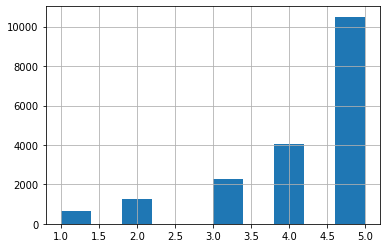

In [ ]:
df['Rating'].hist()

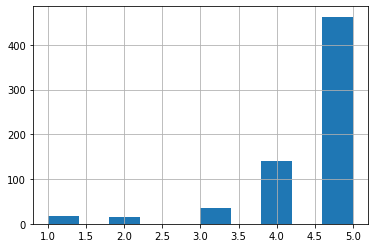

In [ ]:
df[df['Review Text'] == 'nan']['Rating'].hist()

💡 No correlation between empty reviews and rating

⚡ Remove empty reviews

In [ ]:
len(df)

18788

In [ ]:
df = df[df['Review Text'] != 'nan']

In [ ]:
len(df)

18116

# Check duplicate reviews

In [ ]:
review_text_counts_df = df['Review Text'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [ ]:
len(review_text_counts_df[review_text_counts_df['counts'] > 1])

3

In [ ]:
for review in review_text_counts_df[review_text_counts_df['counts'] > 1]['unique_values']:
  print(review)
  print('---------------------------------------')

Lightweight, soft cotton top and shorts. i think it's meant to be a beach cover-up but i'm wearing it as a thin, light-weight summer outfit on these hot hot days. the top has a loose elastic around the bottom which i didn't realize when i ordered it, but i like it and it matches the look in the photos. and the shorts are very low-cut - don't expect them up around your waist. again, i like that. some might want to wear a cami underneath because it's a thin cotton but i'm fine as-is. i bought it i
---------------------------------------
The sweater and skirt are so pretty! they're really soft and have such an easy, comfortable look together. really love this gorgeous outfit.

i am borderline small/medium and kept the size small after trying both on.
---------------------------------------
Love, love these jeans. being short they come right to my ankle. super soft and don?t require any hemming. i ordered my typical jean size of 26 and they fit like a glove. would love to have these in bla

In [ ]:
df[df['Review Text'].isin(review_text_counts_df[review_text_counts_df['counts'] > 1]['unique_values'])]

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2527,21888,1022,37,,"Love, love these jeans. being short they come ...",5,1,0,General,Bottoms,Jeans
5045,10708,632,60,Cute cover-up or summer top & shorts!,"Lightweight, soft cotton top and shorts. i thi...",5,1,8,Initmates,Intimate,Lounge
6497,11074,628,60,Cute cover-up or summer top & shorts!,"Lightweight, soft cotton top and shorts. i thi...",5,1,2,Initmates,Intimate,Lounge
13910,16988,993,60,Soft & beautiful!,The sweater and skirt are so pretty! they're r...,5,1,1,General,Bottoms,Skirts
15356,9447,1022,37,,"Love, love these jeans. being short they come ...",5,1,0,General,Bottoms,Jeans
18558,21470,895,60,Soft & beautiful!,The sweater and skirt are so pretty! they're r...,5,1,5,General Petite,Tops,Fine gauge


⚡ No need to keep duplicate reviews

In [ ]:
len(df)

18116

In [ ]:
df.drop_duplicates(subset='Review Text', inplace=True)

In [ ]:
len(df)

18113

# Fix whitespaces

In [ ]:
df['Review Text'].str.contains('\n').sum()

1634

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x.split()))

In [ ]:
df['Review Text'].str.contains('\n').sum()

0

# Check shortest/longest reviews and titles

In [ ]:
df['Title Length'] = df['Title'].apply(lambda x: len(x.split()))
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))

In [ ]:
df.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
0,1214,1094,52,Great dress but not in green,Beautiful dress. good quality. tts. i'm 5 feet...,3,1,1,General,Dresses,Dresses,6,56
1,1917,1066,72,"Love! but more tall options, please!",These pants are so great. i am 5'10 and the ta...,5,1,11,General Petite,Bottoms,Pants,6,82
2,18277,854,39,Love it!,"I bought a size s in the navy, and m in the ne...",5,1,0,General,Tops,Knits,2,69
3,10757,864,34,Runs big but cute buy on sale,Loved this shirt but it runs pretty big. i'm n...,3,1,1,General Petite,Tops,Knits,7,51
4,10782,1110,43,Looks better than the picture!,I love this dress! i was trying on some dresse...,5,1,0,General Petite,Dresses,Dresses,5,105


In [ ]:
df.sort_values('Title Length', ascending=False).head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
5056,8121,833,51,It's not a black and white top - it's ecru and...,I suppose i would have kept this top i hadn't ...,3,0,3,General,Tops,Blouses,12,29
10189,18717,829,28,If you have red hair you have to get this in k...,This top is soft feeling and i appreciate that...,5,1,0,General,Tops,Blouses,12,55
12433,10523,1110,63,The print is a work of art - i love this dress,The delicate print and coloring are stunning. ...,5,1,2,General,Dresses,Dresses,12,93
2060,18675,1068,65,Love the style - hate the dye left on my skin,"I recommend this product, but with the followi...",2,1,0,General Petite,Bottoms,Pants,11,66
11530,11042,1093,46,Gorgeous dress - but a little heavy for a hot day,"Ordered this online in a petite 4. (i'm 5'3""/1...",5,1,4,General,Dresses,Dresses,11,98


In [ ]:
df[df['Title Length'] > 0].sort_values('Title Length', ascending=True).head(10)

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
4347,3263,1011,31,Feminine,I love the print and style of the skirt. it is...,4,1,0,General,Bottoms,Skirts,1,97
13636,18709,864,34,Love!,I wore this for the first time today and got s...,5,1,0,General,Tops,Knits,1,86
13225,16682,1110,33,Effortless!,I tried this on a whim during the sale with no...,5,1,1,General,Dresses,Dresses,1,102
9519,7067,862,50,Lightweight,"This lift weight cardigan is true to size, per...",3,1,0,General,Tops,Knits,1,23
15565,17509,1086,26,Love!,I love this dress. i'm 6' so it's a tad bit sh...,4,1,1,General,Dresses,Dresses,1,70
1702,6171,873,48,Love,I am very petite and ordered the xs. it is too...,5,1,2,General,Tops,Knits,1,106
3473,18661,838,41,Oversized,This shirt fit really really big! i ordered an...,3,1,7,General Petite,Tops,Blouses,1,36
17991,15771,895,64,Crazy!,It's really crazy how much i like this sweater...,5,1,0,General Petite,Tops,Fine gauge,1,71
12114,5166,865,44,Perfect,This tank is perfect for summer since it pairs...,5,1,1,General,Tops,Knits,1,92
5381,2191,872,37,Amazing,This shirt looks and feels fabulous. i got bla...,5,1,0,General,Tops,Knits,1,25


💡 No insights from Title Length

In [ ]:
data_table.enable_dataframe_formatter()
df.sort_values('Review Length', ascending=False).head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
1074,16880,834,63,,I love maeve tops. i love the material and fee...,3,0,3,General,Tops,Blouses,0,115
11277,12731,1110,49,Couldn't wait to see this in person!,I had my eye on this dress since it fist came ...,5,1,1,General,Dresses,Dresses,7,114
11060,15508,1099,43,Romantic and pretty,I was walking to the fitting room and i saw tw...,5,1,5,General Petite,Dresses,Dresses,3,114
4789,13361,975,54,Pleasant surprise!,This outfit was online for months with no revi...,5,1,1,General Petite,Jackets,Jackets,2,112
13874,6697,865,53,"Odd fit, beautiful design but poor execution",I wanted to love this blouse so much. but try ...,1,0,7,General,Tops,Knits,7,111


💡 Seems like longest reviews are truncated :/ also in original file :(

In [ ]:
data_table.disable_dataframe_formatter()
df.sort_values('Review Length', ascending=True).head(10)

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
18689,859,886,27,,Great style!,5,1,1,General Petite,Tops,Knits,0,2
10704,13399,927,36,Buy this!,Fits perfect!,5,1,0,General Petite,Tops,Sweaters,2,2
2136,11518,1066,21,Beautiful pant,Great structure,5,1,0,General Petite,Bottoms,Pants,2,2
18059,7785,820,50,Another beautiful white top,Great fit,5,1,0,General Petite,Tops,Blouses,4,2
2359,15653,1089,29,Perfect bride dress,Fits perfect.,5,1,0,General,Dresses,Dresses,3,2
7258,17317,1022,60,Comfy yer dressy,Love these jeans.,5,1,0,General,Bottoms,Jeans,3,3
6367,5925,862,55,,Beautiful and delicate!!,5,1,3,General,Tops,Knits,0,3
9696,7521,941,54,Great pullover !,Soft and sweet,5,1,0,General Petite,Tops,Sweaters,3,3
17710,9121,414,61,,"Very pretty, romantic",3,0,3,Initmates,Intimate,Sleep,0,3
14177,23041,687,30,A little short,Overall very pretty.,5,1,1,Initmates,Intimate,Intimates,3,3


💡 Review is 'Very pretty, romantic' and rating is 3 :/ 

# Fix potential HTML

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: BeautifulSoup(x).get_text(separator=' ')) 
df['Title'] = df['Title'].apply(lambda x: BeautifulSoup(x).get_text(separator=' ')) 

# Check unwanted characters

In [ ]:
characters = ['#', '&', '@', '_']
for c in characters:
  print(c, df['Review Text'].str.contains(c).sum())

# 246
& 455
@ 6
_ 36


In [ ]:
for x in df[df['Review Text'].str.contains('@')]['Review Text'][:10]:
  print(x)
  print('--------------------------------------')

Wow.. love this blazer! it's not as structured as some blazers , but the woven fabric hugs in the right places. fantastic addition and great alternative to the good'ol black blazer.. great versatility work to play. nice weight for fall, but will also do well for my fl winter. it's longer than some of my other blazers, but i like it.. with the front pockets as they are, it makes for a unique design that gets noticed. i got the size 4 and i have broad shoulders for someone @ 135lbs.. makes for a n
--------------------------------------
I am 5' and 3/4" tall. too "tall" for most petite pants and too short for regular pants. these ran a little big. i weigh @140 lbs. and have been wearing mostly 28s and 29s, which is what i ordered. the 29s were a tad too big around the waist. the 28 fit but were so long that they looked like clown pants on me. i am in the conundrum that i can never find cropped pants that fit because i am in between petite and regular height sizing. these were a perfect ex

💡 somewhere @ means 'at', somewhere can be removed

In [ ]:
for x in df[df['Review Text'].str.contains('#')]['Review Text'][:10]:
  print(x)
  print('--------------------------------------')

As is true of a bunch of the fall clothing photos, the colors are totally washed out in these model images which is such a shame. the embroidery is bright and vivid and totally unique on this! the bib area is actually a soft corduroy which i think is nice to transition into fall and winter. in terms of fit, i do feel like this is maybe geared more towards the slender build - it is a slim cut which i found really flattering for me since i sometimes swim in tunics. at 5'7", 128# with a very small
--------------------------------------
Love this so much because it's so soft, pliable and fits wonderfully with all of my fall wardrobe. i ordered the plum color, which looks brown to me. was advised to size up and glad i did. i bought large petite and my stats are 5'3" 135# 38/28/35.
--------------------------------------
Everything about this dress is perfect for my body type. i used the tie belt as a cinch to gather the fabric and made the silhouette into a loose fit & flare. i have a large 

💡 1. most commonly # goes after number, in most cases it is related to weight (in pounds(lbs)), replace with lbs ⚡</br>
2. `&#39;` represents single quote, which should be replaced ⚡

In [ ]:
df['Review Text']  = df['Review Text'].apply(lambda x: regex.sub(r'(?<=[0-9]+)#', ' lbs', x))
df['Review Text'] = df['Review Text'].apply(lambda x: x.replace("amp;", ""))
df['Review Text'] = df['Review Text'].apply(lambda x: x.replace("&#39;", "'")) 

# Check links

In [ ]:
print('http in title >>', df['Review Text'].str.contains('http').sum())
print('http in review >>', df['Review Text'].str.contains('http').sum())

http in title >> 0
http in review >> 0


# Check non-ascii characters

In [ ]:
df['Not ascii characters title'] = df['Title'].apply(lambda x: not x.isascii())
df['Not ascii characters review'] = df['Review Text'].apply(lambda x: not x.isascii())

print('Not ascii titles: ', str(round(len(df[df['Not ascii characters title']])/len(df)*100, 2)) + ' %')
a = len(df[df['Not ascii characters review']])
b = len(df)
c = round(len(df[df['Not ascii characters review']])/len(df)*100, 2)
print(f'Not ascii reviews: {a} / {b} = {c} %')

Not ascii titles:  0.0 %
Not ascii reviews: 25 / 18113 = 0.14 %


In [ ]:
for x in df[df['Not ascii characters review']]['Review Text']:
    print(x)
    print('------------------------')

I love this dress! the colors work well with my olive skin color, it has pockets and it has a hi-lo front/back.â â i have slim hips so the tie waist is very flattering which gives an hourglass figure.â â i am 5?2?, 116 lbs and a 32d.â â i usually need a petite size because retailer dresses run a little long on me. but i was able to get away with getting an xs regular because of the hi-lo length. it fell perfectly above my knee.
------------------------
Tried on standard xs and the photo on-line is slightly misleading as i thought that there were more colors involved in the embroidery pattern. in person, the pattern is not as intricate with only 2 solid colors. the body of the shirt is light, airy/billowy, not as form grazing like on the model..which i don't mind. i still love the top but would have to go for a petite xs or even a petite xxs so that it would be a little more fitted all around. note that the embroidery on the dã©colletã© feels lik
------------------------
The appliquã© o

💡 words with non-ascii characters: <br/>
<br/>
â â   x1 <br/>
dã©colletã©   x1 <br/>
appliquã©   x10 <br/> 
derriã©re   x1 <br/>
ombrã©   x4<br/>
derriã¨re   x4<br/>
fiancã©   x1<br/>
dã©colletage   x1<br/>
risquã©   x1<br/>
aprã¨s-ski   x1<br/>
<br/>
According to [this](https://www.i18nqa.com/debug/utf8-debug.html) source:<br/>
ã© => é<br/>
ã¨ => é<br/>
<br/>
⚡ <br/>
â â => remove <br/>
ã© and ã¨ => replace with simple e <br/>

In [ ]:
df['Review Text'] = df['Review Text'].str.replace('â â', '')
df['Review Text'] = df['Review Text'].str.replace('ã©', 'e')
df['Review Text'] = df['Review Text'].str.replace('ã¨', 'e')

In [ ]:
df['Not ascii characters review'] = df['Review Text'].apply(lambda x: not x.isascii())
print(f'Not ascii reviews: ', len(df[df['Not ascii characters review']]))

Not ascii reviews:  0


# Check emojis

In [ ]:
!pip install emot

In [ ]:
import emot 
emot_obj = emot.core.emot()
print('Emoji') 
print(emot_obj.emoji('🙂'))
print('\nNo emoji') 
print(emot_obj.emoji(' text '))
print('\nEmoticon') 
print(emot_obj.emoticons(' :) '))
print('\nNo emoticon') 
print(emot_obj.emoticons(' text '))

Emoji
{'value': ['🙂'], 'location': [[0, 1]], 'mean': [':slightly_smiling_face:'], 'flag': True}

No emoji
{'value': [], 'location': [], 'mean': [], 'flag': False}

Emoticon
{'value': [':)'], 'location': [[1, 3]], 'mean': ['Happy face or smiley'], 'flag': True}

No emoticon
{'value': [], 'location': [], 'mean': [], 'flag': False}


In [ ]:
df['Emoji in Title'] = df['Title'].apply(lambda x: emot_obj.emoji(x)['flag'])
df['Emoji in Review Text'] = df['Review Text'].apply(lambda x: emot_obj.emoji(x)['flag'])
df['Emoticons in Title'] = df['Title'].apply(lambda x: emot_obj.emoticons(x)['flag'])
df['Emoticons in Review Text'] = df['Review Text'].apply(lambda x: emot_obj.emoticons(x)['flag'])

print('Number of titles with emojis: ', len(df[df['Emoji in Title']]))
print('Number of reviews with emojis: ', len(df[df['Emoji in Review Text']]))
print('Number of titles with emoticons: ', len(df[df['Emoticons in Title']]))
print('Number of reviews with emoticons: ', len(df[df['Emoticons in Review Text']]))

Number of titles with emojis:  0
Number of reviews with emojis:  0
Number of titles with emoticons:  38
Number of reviews with emoticons:  370


In [ ]:
def get_emoticons_dict(column):
  emoticons_title_dict = {}
  for x in df[df[f'Emoticons in {column}']][column]:
    result = emot_obj.emoticons(x)
    for emoticon in result['value']:
      if emoticon not in emoticons_title_dict:
        emoticons_title_dict[emoticon] = []
      emoticons_title_dict[emoticon].append(x)
  return emoticons_title_dict

def emoticons_to_count(emoticons_dict):
  items = emoticons_dict.items()
  items = [(item[0], len(item[1])) for item in items]
  items = sorted(items, key=lambda x: x[1], reverse=True)
  return items

In [ ]:
emoticons_title_dict = get_emoticons_dict('Title')
emoticons_to_count(emoticons_title_dict)

[(':(', 16),
 (':)', 8),
 ('d:', 4),
 (':-(', 3),
 (':/', 2),
 (';)', 2),
 ('=)', 1),
 ('=/', 1),
 (':))', 1)]

In [ ]:
top = 2
for emoticon in emoticons_title_dict:
  print(emoticon)
  for sentence in emoticons_title_dict[emoticon][:top]: 
    print(sentence)
  print('-------------------------------')

:)
Great top for pregnant women:)
The one that didn't get away! :)
-------------------------------
:-(
Too long :-(
Not for single girls :-(
-------------------------------
:(
Adorable but runs small in the bust :(
So disappointed :(
-------------------------------
d:
Be warned: these pants snag on everything
Dissapointed:(
-------------------------------
:/
Ehh not a fan :/
Beautiful. great quality. low cut bottom :/
-------------------------------
;)
Ok curvy peeps! ;)
Fun ;)
-------------------------------
=)
Love it =))
-------------------------------
=/
Jolly arms =/= jolly jacket
-------------------------------
:))
Happy :))
-------------------------------


💡 Not all emojis detected with this library are valid!

In [ ]:
emoticons_review_dict = get_emoticons_dict('Review Text')
emoticons_to_count(emoticons_review_dict)

[(':)', 164),
 (':(', 80),
 (';)', 35),
 ('d:', 33),
 (':-)', 32),
 (':-(', 12),
 (':/', 8),
 (':))', 5),
 ('%)', 5),
 (':>', 2),
 (':-))', 1),
 ('=]', 1),
 ('*)', 1),
 (':#', 1),
 (':o', 1),
 ('=)', 1),
 (':-0', 1)]

In [ ]:
for emoticon in emoticons_review_dict:
  if len(emoticons_review_dict[emoticon]) < 5:
    print(emoticon)
    for sentence in emoticons_review_dict[emoticon]: 
      print(sentence)
    print('-------------------------------')

:-))
I love the color combination, and the bodice is very falttering. it has a tiny bit of stretch. the tulle is also feminine, i love that i could wear this with a moto jacket... sizing: no need for petite, it was short enough in regualr size. i think petite would have been too short (unless you are younger:-))
-------------------------------
=]
I tried this top on in the store before i ordered it online. i'm a size 2/4 (varies), and i ordered it in a size 2. i've been searching the perfect, fitted, white, button-down blouse for weeks, and i love this top! it's figure flattering, true to size, and a cute, classy alternative to your basic white button down. i can't wait to wear it! =]
-------------------------------
*)
I feel that for this price, i should love this top (and i wanted to). however, the price is on the high side for a relatively basic top, and there were a few things about it that could be improved. pros: i ordered a medium and feel that it's pretty true to size. addition

In [ ]:
emoticon = 'd:'
top = 5
for sentence in emoticons_review_dict[emoticon][:top]:
  print(sentence)
  print('-------------------------------')

Here's what i liked: great shape through body, cool empire waist. and good length loved the color, more rust than red. material was somewhat light which liked since i often get overheated in turtlenecks. here's what i disliked: the sleeves!! the reason they only show the model with her arms against her body is because the sleeves are ridiculous. they are just too big and too flowy. they will always be in the way of everything and there is no way to roll or push up.
-------------------------------
Here's what i liked: great shape through body, cool empire waist. and good length loved the color, more rust than red. material was somewhat light which liked since i often get overheated in turtlenecks. here's what i disliked: the sleeves!! the reason they only show the model with her arms against her body is because the sleeves are ridiculous. they are just too big and too flowy. they will always be in the way of everything and there is no way to roll or push up.
----------------------------

In [ ]:
def fix_emoticons(row):
  if row['Emoticons in Title']:
    row['Title'] = row['Title'].replace('d:(', 'd :(')
    row['Title'] = row['Title'].replace('=))', '=)')
  if row['Emoticons in Review Text']:
    row['Review Text'] = row['Review Text'].replace('d:(', 'd :(')
    row['Review Text'] = row['Review Text'].replace('=))', '=)')
  return row

emoticons_to_ignore = ['=/', 'd:', '%)', '*)']

def remove_emoticons(row):
  if row['Emoticons in Title']:
    result = emot_obj.emoticons(row['Title'])
    for emoticon in result['value']:
      if emoticon not in emoticons_to_ignore:
        row['Title'] = row['Title'].replace(emoticon, ' ')
  if row['Emoticons in Review Text']:
    result = emot_obj.emoticons(row['Review Text'])
    for emoticon in result['value']:
      if emoticon not in emoticons_to_ignore:
        row['Review Text'] = row['Review Text'].replace(emoticon, ' ')
  return row

def replace_emoticons(row):
  if row['Emoticons in Title']:
    result = emot_obj.emoticons(row['Title'])
    for emoticon, meaning in zip(result['value'], result['mean']):
      if emoticon not in emoticons_to_ignore:
        row['Title'] = row['Title'].replace(emoticon, f' {meaning} ')
  if row['Emoticons in Review Text']:
    result = emot_obj.emoticons(row['Review Text'])
    for emoticon, meaning in zip(result['value'], result['mean']):
      if emoticon not in emoticons_to_ignore:
        row['Review Text'] = row['Review Text'].replace(emoticon, f' {meaning} ')
  return row

df = df.apply(lambda row: fix_emoticons(row), axis=1)

df_removed_emoticons = deepcopy(df)
df_replaced_emoticons = deepcopy(df)
df_removed_emoticons = df_removed_emoticons.apply(lambda row: remove_emoticons(row), axis=1)
df_replaced_emoticons = df_replaced_emoticons.apply(lambda row: replace_emoticons(row), axis=1)

In [ ]:
df[df['Emoticons in Title']]['Title'].head()

70              Great top for pregnant women:)
1416          The one that didn't get away! :)
1902                              Too long :-(
2192    Adorable but runs small in the bust :(
2350                        So disappointed :(
Name: Title, dtype: object

In [ ]:
df_replaced_emoticons[df_replaced_emoticons['Emoticons in Title']]['Title'].head()

70      Great top for pregnant women Happy face or smi...
1416    The one that didn't get away!  Happy face or s...
1902              Too long  Frown, sad, andry or pouting 
2192    Adorable but runs small in the bust  Frown, sa...
2350       So disappointed  Frown, sad, andry or pouting 
Name: Title, dtype: object

In [ ]:
df_removed_emoticons[df_removed_emoticons['Emoticons in Title']]['Title'].head()

70              Great top for pregnant women 
1416          The one that didn't get away!  
1902                               Too long  
2192    Adorable but runs small in the bust  
2350                        So disappointed  
Name: Title, dtype: object

# Save cleaned dataset

Fix whitespaces again

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x.split()))
df_removed_emoticons['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x.split()))
df_replaced_emoticons['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x.split()))
df['Title'] = df['Title'].apply(lambda x: ' '.join(x.split()))
df_removed_emoticons['Title'] = df['Title'].apply(lambda x: ' '.join(x.split()))
df_replaced_emoticons['Title'] = df['Title'].apply(lambda x: ' '.join(x.split()))

Remove duplicates again

In [ ]:
print('df_removed_emoticons')
print(len(df_removed_emoticons))
df_removed_emoticons.drop_duplicates(subset='Review Text', inplace=True)
print(len(df_removed_emoticons))
print()
print('df_replaced_emoticons')
print(len(df_replaced_emoticons))
df_replaced_emoticons.drop_duplicates(subset='Review Text', inplace=True)
print(len(df_replaced_emoticons))
print()
print('df')
print(len(df))
df.drop_duplicates(subset='Review Text', inplace=True)
print(len(df))

df_removed_emoticons
18113
18113

df_replaced_emoticons
18113
18113

df
18113
18113


In [ ]:
df.to_csv('train_clean_with_emoticons.csv', index=False)
df_removed_emoticons.to_csv('train_clean_removed_emoticons.csv', index=False)
df_replaced_emoticons.to_csv('train_clean_replaced_emoticons.csv', index=False)